# 网络中的网络（NiN）
:label:`sec_nin`

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
*网络中的网络*（*NiN*）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 :cite:`Lin.Chen.Yan.2013`

## (**NiN块**)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。
NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。
如果我们将权重连接到每个空间位置，我们可以将其视为$1\times 1$卷积层（如 :numref:`sec_channels`中所述），或作为在每个像素位置上独立作用的全连接层。
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

 :numref:`fig_nin`说明了VGG和NiN及它们的块之间主要架构差异。
NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [5]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。
NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，输出通道数量与AlexNet中的相同。
每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。


In [6]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

我们创建一个数据样本来[**查看每个块的输出形状**]。


In [7]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似。


loss 0.338, train acc 0.876, test acc 0.840
1041.3 examples/sec on mps


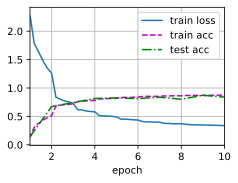

In [8]:
lr, num_epochs, batch_size = 0.03, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, torch.device('mps'))

torch.Size([64, 1, 224, 224])
torch.Size([6, 224, 224])


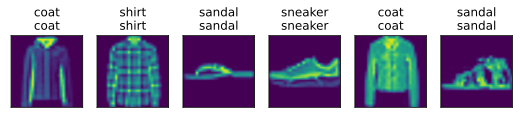

In [24]:
def predict_ch3_modify(net, test_iter, s, e, device=None):
    """Predict labels (defined in Chapter 3).

    Defined in :numref:`sec_softmax_scratch`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in test_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            trues = d2l.get_fashion_mnist_labels(y)

            # Move predictions to CPU before converting to NumPy
            preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1).cpu())
            print(X.shape)
            titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
            print(d2l.reshape(X[s:e].cpu(), (e - s, 224, 224)).shape)
            d2l.show_images(
                d2l.reshape(X[s:e].cpu(), (e - s, 224, 224)), 
                1, e - s, 
                titles=titles[s:e])
            break

    # 
    # with torch.no_grad():
    #     for X, y in test_iter:
    #         if isinstance(X, list):
    #             # Required for BERT Fine-tuning (to be covered later)
    #             X = [x.to(device) for x in X]
    #         else:
    #             X = X.to(device)
    #         y = y.to(device)
    #         trues = d2l.get_fashion_mnist_labels(y)
    #         preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    #         titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    #         d2l.show_images(
    #             d2l.reshape(X[0:n], (n, 224, 224)), 1, n, titles=titles[0:n])


predict_ch3_modify(net, test_iter, 6, 12)

## 小结

* NiN使用由一个卷积层和多个$1\times 1$卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
* NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
* 移除全连接层可减少过拟合，同时显著减少NiN的参数。
* NiN的设计影响了许多后续卷积神经网络的设计。

## 练习

1. 调整NiN的超参数，以提高分类准确性。
1. 为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。
1. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    1. 计算量是多少？
    1. 训练期间需要多少显存？
    1. 预测期间需要多少显存？
1. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？


[Discussions](https://discuss.d2l.ai/t/1869)
